In [2]:
import os 
import json
import pandas as pd
import seaborn as sns
import numpy as np
import math

import pandas as pd
import matplotlib.pyplot as plt

from utils.analysys_utils import list_experiments_in_dir

sns.set()

In [3]:
experiments_path = os.path.join(os.getcwd(), "runs", "momentum_exps", "sidarthe_extended", "Italy")
figs_path = os.path.join(experiments_path, "figs") 
if not os.path.exists(figs_path):
    os.makedirs(figs_path)
experiments = list_experiments_in_dir(experiments_path)


In [4]:
data = []
indexes = []

for exp in experiments:
    try: # avoid NaNs
        val_loss = exp['final']['val_risks']['nrmse']
    except:
        val_loss = np.nan
        #print(f"{exp['uuid']}")
        
    momentum = exp['settings']['momentum']
    if(momentum):
        m = exp['settings']['m']
        a = exp['settings']['a']
    else:
        m = 'none'
        a = 'none'

    indexes.append((m,a))

    data.append({
        'val_loss': val_loss,
        "momentum": momentum,
        "m": m,
        "a": a
    })


index = pd.MultiIndex.from_tuples(indexes, names=['m','a'])
df = pd.DataFrame(data,index=index)


df_mT = df.query("momentum").astype({'a': 'float32'}).query('a >= 0.')
df_mF = df.query("not momentum").reset_index(drop=True)

In [5]:
m_index = df_mT.index.unique('m').sort_values()
a_index = df_mT.index.unique('a').sort_values()

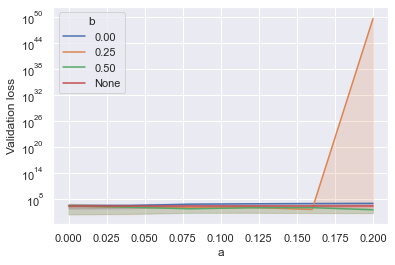

In [6]:
# plot by fixing m

pl, ax = plt.subplots()
ax.set_yscale('log')
for m in m_index[::5]:
    df_m = df_mT.loc[m]
    sns.lineplot(data=df_m, x='a', ax=ax, y='val_loss', label=f"{m:.2f}",legend='brief')

# add band for baseline (no momentum)
band_data = []

for i in range(0,len(df_mF)):
    val_loss = df_mF.iloc[i]['val_loss']
    band_data.append({
        'val_loss': val_loss,
        'a': a_index[0]
    })
    band_data.append({
        'val_loss': val_loss,
        'a': a_index[-1]
    })

band_df = pd.DataFrame(band_data)

plot = sns.lineplot(data=band_df, x='a', ax=ax, y='val_loss', label='None', legend='brief')

plot.set(ylabel="Validation loss")
plot.get_legend().set_title("b")
plot.get_figure().savefig(os.path.join(figs_path, "varying_a.pdf"))

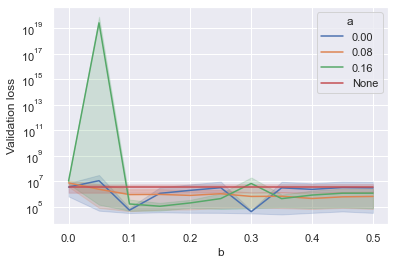

In [8]:
pl, ax = plt.subplots()
ax.set_yscale('log')

for a in a_index[::2]:
    df_a = df_mT.xs(a, axis=0, level=1)
    plot = sns.lineplot(data=df_a, x='m', ax=ax, y='val_loss', label=f"{a:.2f}",legend='brief')


# add band for baseline (no momentum)
band_data = []

for i in range(0,len(df_mF)):
    val_loss = df_mF.iloc[i]['val_loss']
    band_data.append({
        'val_loss': val_loss,
        'm': m_index[0]
    })
    band_data.append({
        'val_loss': val_loss,
        'm': m_index[-1]
    })

band_df = pd.DataFrame(band_data)

plot = sns.lineplot(data=band_df, x='m', ax=ax, y='val_loss', label='None', legend='brief')

plot.set(xlabel="b", ylabel="Validation loss")
plot.get_legend().set_title("a")

plot.get_figure().savefig(os.path.join(figs_path, "varying_m.pdf"))